In [78]:
%load_ext autoreload
%autoreload 2
# Import everything that you use here. The only packages allowed are from bm-336546
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part I: Loss minimization with gradient descent

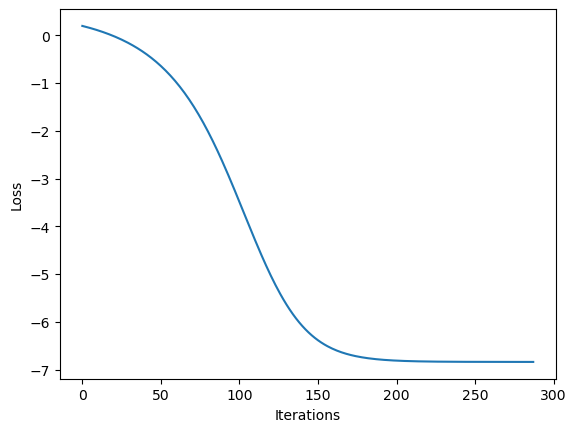

Optimal weights: [0.00163421 0.49657586]
Final loss at optimal weights: -6.837199622836203


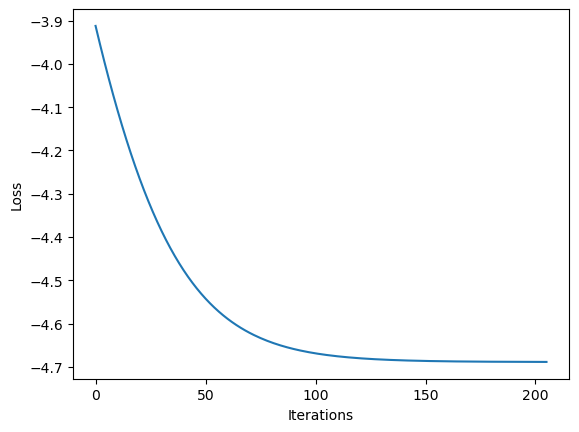

Optimal weights: [ 0.         -1.90886775]
Final loss at optimal weights: -4.688349487754756


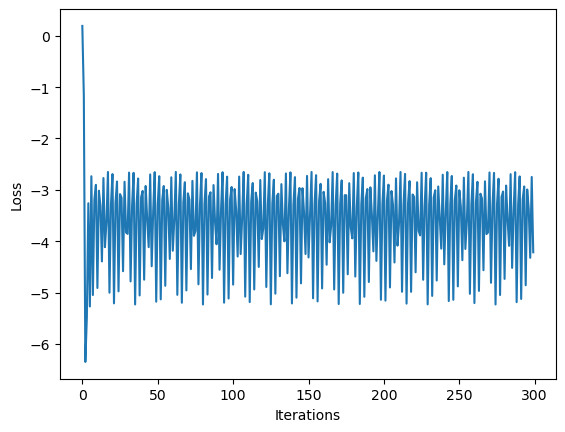

Optimal weights: [0.49146027 0.47730772]
Final loss at optimal weights: -4.216487960541399


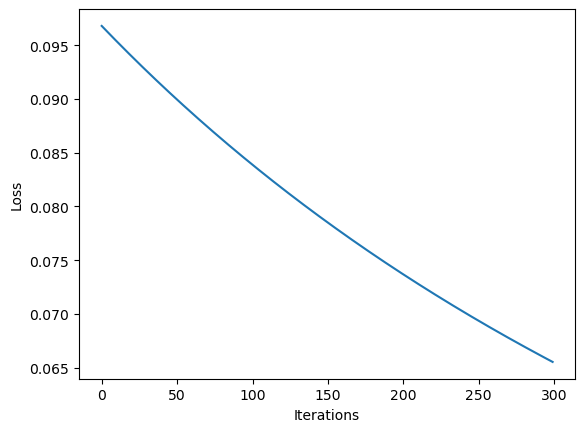

Optimal weights: [2.09398322 2.02210144]
Final loss at optimal weights: 0.06552624321008416


In [79]:
# 1.2 GD algorithm
def loss_function(w1, w2, lmbda):
    return -10 * (0.4 * np.cos(w1) - w1**2 - 0.2 * w2**7 + np.sin(w2)) * np.exp(-w1**2 - w2**2) + lmbda * (w1**2 + w2**2)

def gradient(w1, w2, lmbda):
    df_dw1 = (-20*w1**3 + 4*np.sin(w1) + w1*(-4*w2**7 + 20*np.sin(w2) + 8*np.cos(w1) + 20)) * np.exp(-w1**2 - w2**2) + 2 * lmbda * w1
    df_dw2 = (-4*w2**8 + 14*w2**6 - 10*np.cos(w2) + w2*(-20*w1**2 + 20*np.sin(w2) + 8*np.cos(w1))) * np.exp(-w1**2 - w2**2) + 2 * lmbda * w2
    return np.array([df_dw1, df_dw2])

def grad_desc(w01, w02, eta, lmbda = 0):
    w = np.array([w01, w02])
    iterations = 0
    loss_values = []

    while iterations < 300:
        grad = gradient(w[0], w[1], lmbda)
        w_new = w - eta * grad
        loss = loss_function(w[0], w[1], lmbda)

        if np.linalg.norm(w_new - w) < 1e-4:
            break

        w = w_new
        iterations += 1
        loss_values.append(loss)

    plt.plot(range(iterations), loss_values)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    if lmbda:
        plt.title(f'lambda={lmbda}')
    plt.show()

    print(f"Optimal weights: {w}")
    print(f"Final loss at optimal weights: {loss}")

# Run the function with different initializations and learning rates
grad_desc(1, 1, 0.001)
grad_desc(0, -2.2, 0.001)
grad_desc(1, 1, 0.1)
grad_desc(2, 2, 0.001)


Show result for lambda=0.01


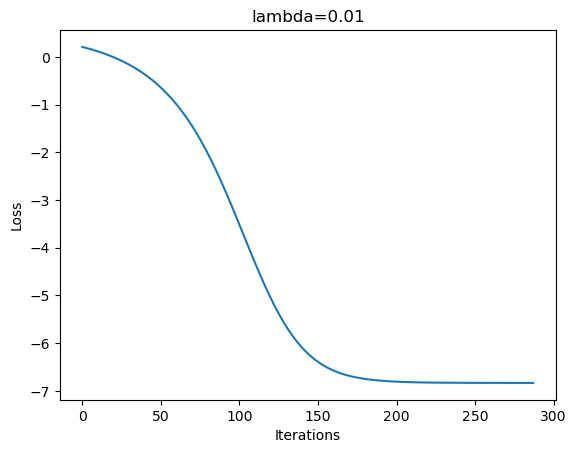

Optimal weights: [0.00160089 0.49614185]
Final loss at optimal weights: -6.834773644258129

Show result for lambda=100


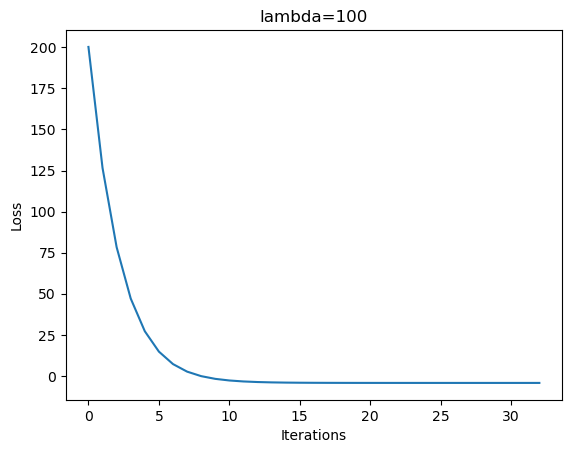

Optimal weights: [0.00017767 0.0480487 ]
Final loss at optimal weights: -4.239099063088176


In [80]:
# 1.5 add regularization
lmbda_vec = [0.01,100]
for lmbda in lmbda_vec:
    print(f'\nShow result for lambda={lmbda}')
    grad_desc(1, 1, 0.001, lmbda)
    plt.show()

# Part II: Linear vs. nonliner classifiers

In [81]:
X = pd.read_csv('X_data.csv')
X.drop(columns=X.columns[0], axis=1, inplace=True)
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


In [82]:
y = pd.read_csv('y_data.csv')  # read and convert to numpy
y.drop(columns=y.columns[0], axis=1, inplace=True)
y.head()

,y
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


# 2.2.1 Train-test split and preprocess

First of all, divide the dataset into train and test

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.2, 
                                                    random_state=0, stratify=np.ravel(y))

Check for missing values

In [84]:
X_train.isna().sum()/X_train.shape[0]

Age             0.0
Systolic_BP     0.0
Diastolic_BP    0.0
Cholesterol     0.0
dtype: float64

Next, we'll check for outliers in the data

Text(0, 0.5, 'Value')

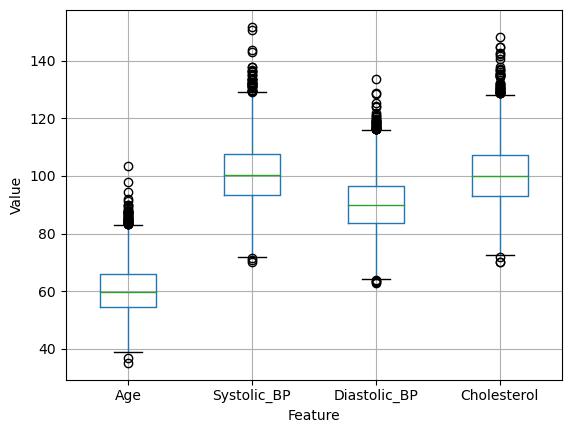

In [85]:
X_train.boxplot()
plt.xlabel('Feature')
plt.ylabel('Value')

Lets remove the ouliers according the definition $outlier > 3Q + 1.5IQR$ or $outlier < 1Q - 1.5IQR$

In [86]:
for col in X_train:
    Q1 = np.percentile(X_train[col],25)
    Q3 = np.percentile(X_train[col],75)
    IQR = Q3 - Q1
    topTh = Q3 + 1.5 * IQR
    bottomTh = Q1 - 1.5 * IQR
    outliers = (X_train[col] > topTh) | (X_train[col] < bottomTh)
    X_train[col][outliers] = np.full((outliers.sum()), np.nan)
    outliers = (X_test[col] > topTh) | (X_test[col] < bottomTh)
    X_test[col][outliers] = np.full((outliers.sum()), np.nan)

After outliers removal:

Text(0, 0.5, 'Value')

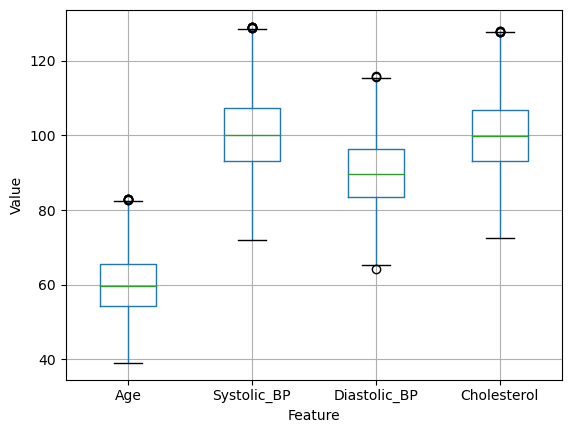

In [87]:
X_train.boxplot()
plt.xlabel('Feature')
plt.ylabel('Value')

Now there are missing values in the dataset. We will fill the Nan values according to the nearest neighbors usign k-NN

In [88]:
X_train.isna().sum()

Age             47
Systolic_BP     40
Diastolic_BP    42
Cholesterol     48
dtype: int64

In [89]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train[:] = imputer.fit_transform(X_train)
X_test[:] = imputer.transform(X_test)

In [90]:
X_train.isna().sum()

Age             0
Systolic_BP     0
Diastolic_BP    0
Cholesterol     0
dtype: int64

Next, scaling the features

In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 2.2.2 Visualization and exploration of the data

Lets look at the standafized features, and check if the distribution is the same for train and test

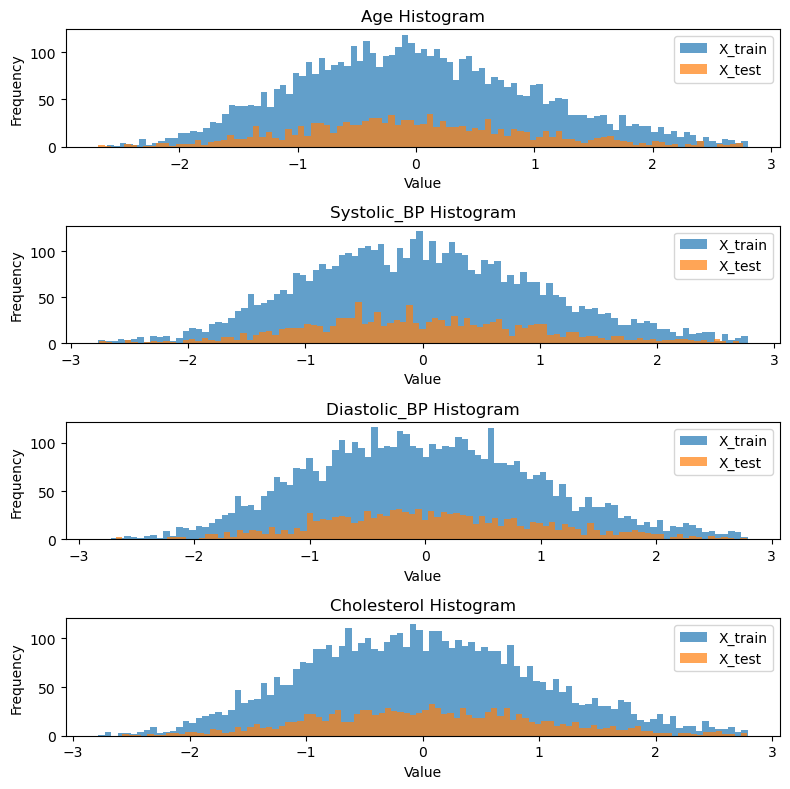

In [111]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8))
for i,((col_name,col_train),(_,col_test)) in enumerate(zip(X_train_std.items(),X_test_std.items())):
    axes[i].hist(col_train, bins=100, alpha=0.7, label='X_train')
    axes[i].hist(col_test, bins=100, alpha=0.7, label='X_test')
    axes[i].set_title(f'{col_name} Histogram')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Also, check that label ratios are the same for train and test:

In [112]:
print(f'Positive sample ratio in train {y_train.sum()/y_train.shape[0]:.2f}')
print(f'Positive sample ratio in test {y_test.sum()/y_test.shape[0]:.2f}')

Positive sample ratio in train 0.51
Positive sample ratio in test 0.51


Now, lets examin the connection between the features

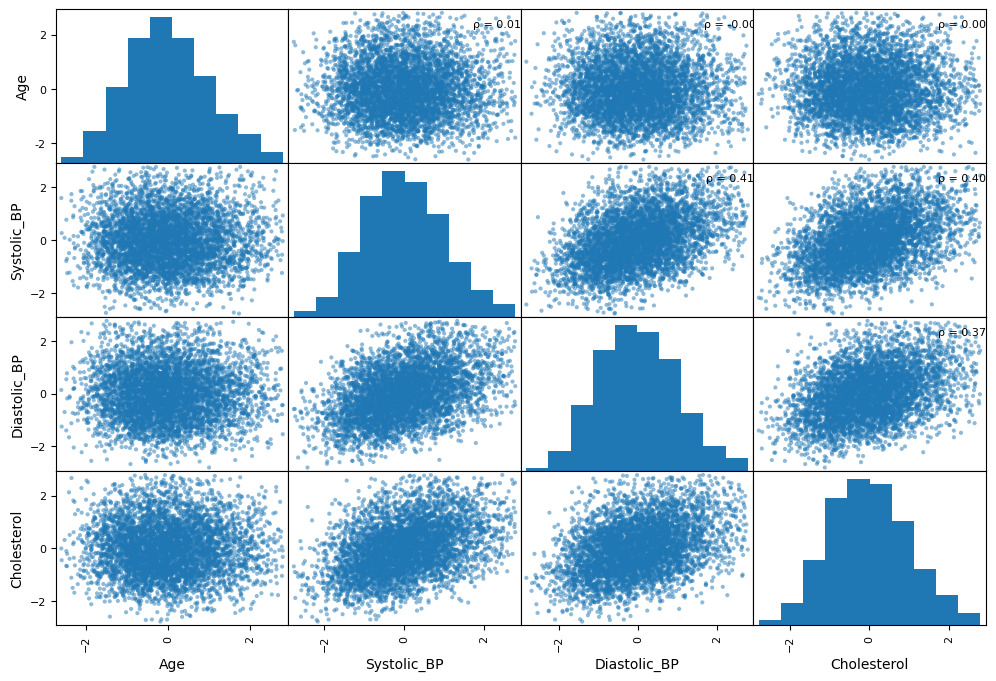

In [110]:
from pandas.plotting import scatter_matrix
scatter_matrix(X_train_std, figsize=(12, 8)) # correlation between chosen variables
axes = np.reshape(plt.gcf().get_axes(), (4,4))
for i, j in zip(*plt.np.triu_indices_from(axes, 1)):
    r = X_train_std.iloc[:, i].corr(X_train_std.iloc[:, j], method='pearson')
    axes[i, j].annotate(f'ρ = {r:.2f}', (0.9, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=8)
plt.show()

Next, Lets examine the relationship between features and label.

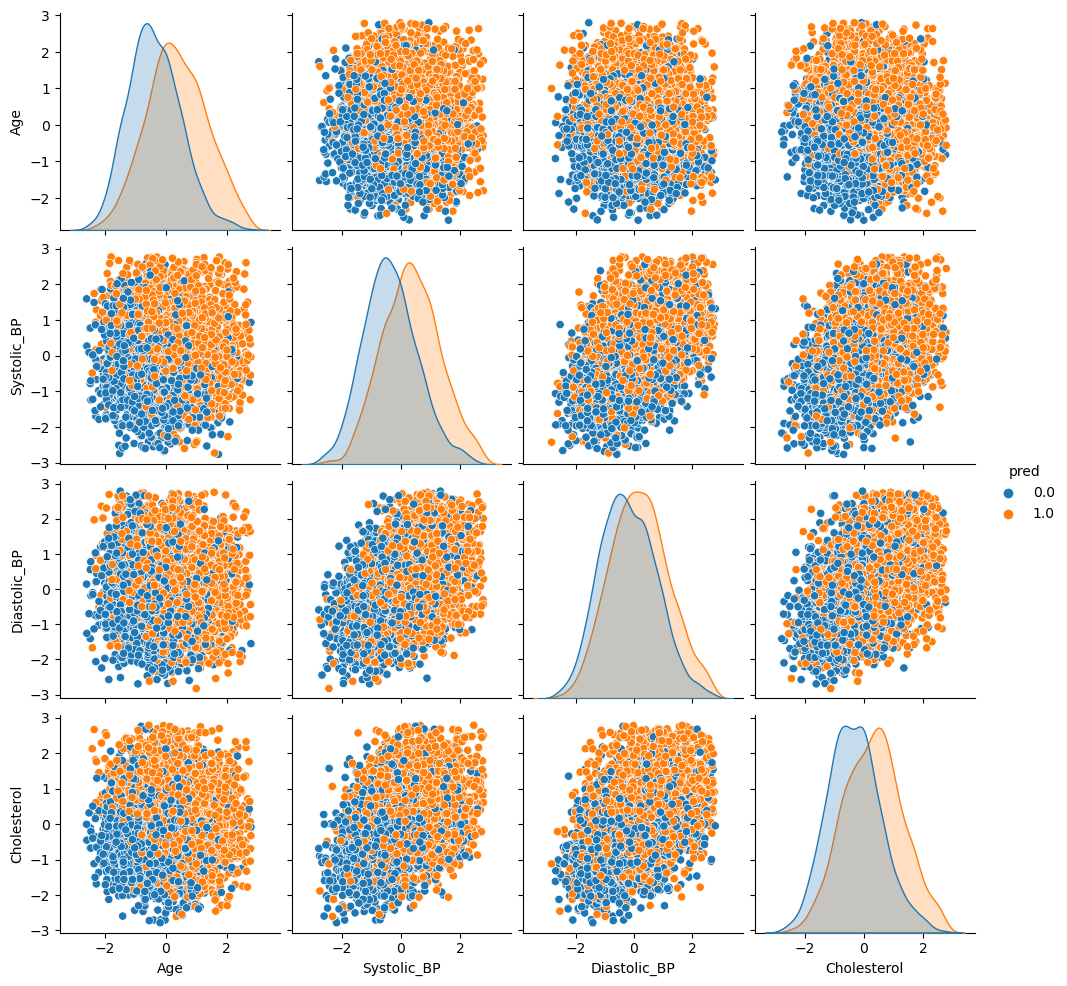

In [96]:
import seaborn as sns
df = X_train_std.copy()
df['pred'] = y_train
sns.pairplot(df,hue='pred')

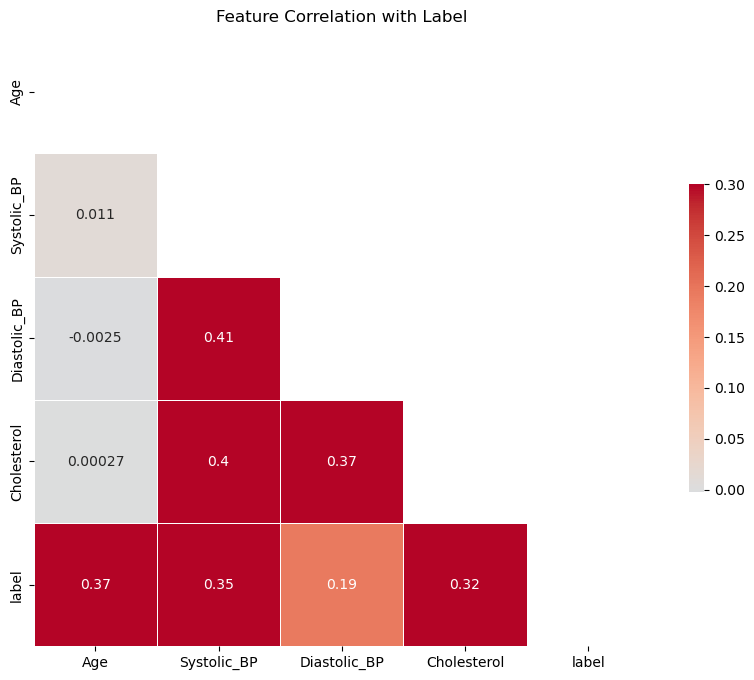

In [107]:
df = pd.concat([X_train_std, pd.Series(y_train, name='label')], axis=1)
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Feature Correlation with Label')
plt.show()

# 2.2.3 Choose, build and optimize ML models 

Now we will move on to optimize the ML model - first, logistic regression:

In [97]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

skf = StratifiedKFold(n_splits=5, random_state=336546, shuffle=True)
log_reg = LogisticRegression(random_state=336546, max_iter=300,solver='saga')
lmbda = np.array([0.001, 0.01, 0.1, 1, 10])
pipe = Pipeline(steps=[('logistic', log_reg)])
lrc = GridSearchCV(estimator=pipe, param_grid={'logistic__C': 1/lmbda, 'logistic__penalty': ['l1','l2']},
                   scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                   refit='roc_auc', verbose=3, return_train_score=True)
lrc.fit(X_train_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END logistic__C=1000.0, logistic__penalty=l1; accuracy: (train=0.735, test=0.776) f1: (train=0.742, test=0.777) precision: (train=0.744, test=0.796) recall: (train=0.739, test=0.759) roc_auc: (train=0.815, test=0.838) total time=   0.0s
[CV 2/5] END logistic__C=1000.0, logistic__penalty=l1; accuracy: (train=0.746, test=0.739) f1: (train=0.752, test=0.739) precision: (train=0.755, test=0.759) recall: (train=0.749, test=0.721) roc_auc: (train=0.820, test=0.819) total time=   0.0s
[CV 3/5] END logistic__C=1000.0, logistic__penalty=l1; accuracy: (train=0.738, test=0.761) f1: (train=0.743, test=0.771) precision: (train=0.750, test=0.762) recall: (train=0.737, test=0.779) roc_auc: (train=0.814, test=0.842) total time=   0.0s
[CV 4/5] END logistic__C=1000.0, logistic__penalty=l1; accuracy: (train=0.744, test=0.736) f1: (train=0.749, test=0.749) precision: (train=0.756, test=0.735) recall: (train=0.742, test=0.763) roc_auc: 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=336546, shuffle=True),
             estimator=Pipeline(steps=[('logistic',
                                        LogisticRegression(max_iter=300,
                                                           random_state=336546,
                                                           solver='saga'))]),
             param_grid={'logistic__C': array([1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01]),
                         'logistic__penalty': ['l1', 'l2']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [98]:
print('Best parameters chosen:')
for param, value in lrc.best_params_.items():
    print(f'{param} = {value}')
print('\n')
print(f'Best Logistic-Regression model AUROC = {lrc.best_score_:.3f}')

Best parameters chosen:
logistic__C = 1.0
logistic__penalty = l1


Best Logistic-Regression model AUROC = 0.819


Second, we will examine SVM with rbf and poly kernels, and different C values

In [99]:
from sklearn.svm import SVC

svc = SVC(probability=True)
skf = StratifiedKFold(n_splits=3, random_state=336546, shuffle=True)
pipe = Pipeline(steps=[('svm', svc)])
svm = GridSearchCV(estimator=pipe, param_grid={'svm__kernel':['poly','rbf'], 'svm__C': np.array([0.01,0.1,1])},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=3, return_train_score=True)
svm.fit(X_train_std, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END svm__C=0.01, svm__kernel=poly; accuracy: (train=0.733, test=0.748) f1: (train=0.744, test=0.754) precision: (train=0.735, test=0.757) recall: (train=0.752, test=0.751) roc_auc: (train=0.806, test=0.812) total time=   1.3s
[CV 2/3] END svm__C=0.01, svm__kernel=poly; accuracy: (train=0.733, test=0.749) f1: (train=0.726, test=0.748) precision: (train=0.768, test=0.772) recall: (train=0.689, test=0.727) roc_auc: (train=0.799, test=0.828) total time=   1.2s
[CV 3/3] END svm__C=0.01, svm__kernel=poly; accuracy: (train=0.748, test=0.711) f1: (train=0.760, test=0.727) precision: (train=0.745, test=0.707) recall: (train=0.776, test=0.748) roc_auc: (train=0.822, test=0.778) total time=   1.2s
[CV 1/3] END svm__C=0.01, svm__kernel=rbf; accuracy: (train=0.742, test=0.743) f1: (train=0.761, test=0.757) precision: (train=0.728, test=0.735) recall: (train=0.796, test=0.781) roc_auc: (train=0.812, test=0.816) total time=   2.5s
[

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=336546, shuffle=True),
             estimator=Pipeline(steps=[('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([0.01, 0.1 , 1.  ]),
                         'svm__kernel': ['poly', 'rbf']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [100]:
print('Best parameters chosen:')
for param, value in svm.best_params_.items():
    print(f'{param} = {value}')
print('\n')
print(f'Best SVM model AUROC = {svm.best_score_:.3f}')

Best parameters chosen:
svm__C = 0.1
svm__kernel = rbf


Best SVM model AUROC = 0.815


Finally, we will check how Random Forest is performing:

In [101]:
from sklearn.ensemble import RandomForestClassifier

randFor = RandomForestClassifier(random_state=336546)
skf = StratifiedKFold(n_splits=5, random_state=336546, shuffle=True)
pipe = Pipeline(steps=[('rfc', randFor)])
rfc = GridSearchCV(estimator=pipe, param_grid={'rfc__criterion':['gini','entropy'], 'rfc__max_features':[None,'sqrt'], 'rfc__max_depth': np.arange(3,8)},
             scoring=['accuracy','f1','precision','recall','roc_auc'], 
             cv=skf, refit='roc_auc', verbose=3, return_train_score=True)
rfc.fit(X_train_std, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END rfc__criterion=gini, rfc__max_depth=3, rfc__max_features=None; accuracy: (train=0.738, test=0.751) f1: (train=0.748, test=0.752) precision: (train=0.739, test=0.771) recall: (train=0.757, test=0.735) roc_auc: (train=0.819, test=0.829) total time=   0.3s
[CV 2/5] END rfc__criterion=gini, rfc__max_depth=3, rfc__max_features=None; accuracy: (train=0.743, test=0.721) f1: (train=0.746, test=0.721) precision: (train=0.761, test=0.741) recall: (train=0.731, test=0.702) roc_auc: (train=0.823, test=0.804) total time=   0.3s
[CV 3/5] END rfc__criterion=gini, rfc__max_depth=3, rfc__max_features=None; accuracy: (train=0.738, test=0.749) f1: (train=0.740, test=0.759) precision: (train=0.757, test=0.750) recall: (train=0.724, test=0.769) roc_auc: (train=0.818, test=0.832) total time=   0.3s
[CV 4/5] END rfc__criterion=gini, rfc__max_depth=3, rfc__max_features=None; accuracy: (train=0.739, test=0.745) f1: (train=0.746, test=0.

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=336546, shuffle=True),
             estimator=Pipeline(steps=[('rfc',
                                        RandomForestClassifier(random_state=336546))]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': array([3, 4, 5, 6, 7]),
                         'rfc__max_features': [None, 'sqrt']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [102]:
print('Best parameters chosen:')
for param, value in rfc.best_params_.items():
    print(f'{param} = {value}')
print('\n')
print(f'Best Random Forest model AUROC = {rfc.best_score_:.3f}')

Best parameters chosen:
rfc__criterion = entropy
rfc__max_depth = 6
rfc__max_features = sqrt


Best Random Forest model AUROC = 0.820


Evaluation on test set:

Logisitic Regression test set Accuracy: 0.717
Logisitic Regression test set F1 Score: 0.726
Logisitic Regression test set AUROC Score: 0.795


c:\Users\Oron\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Oron\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


SVM test set Accuracy: 0.728
SVM test set F1 Score: 0.748
SVM test set AUROC Score: 0.797
Random Forest test set Accuracy: 0.722
Random Forest test set F1 Score: 0.741
Random Forest test set AUROC Score: 0.803


c:\Users\Oron\anaconda3\envs\bm-336546\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


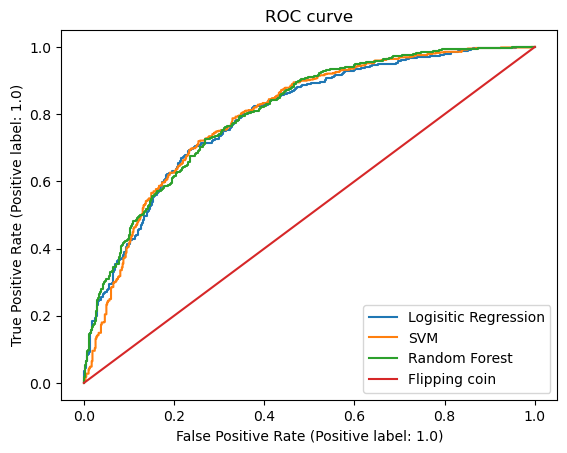

In [103]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_roc_curve

models = [lrc, svm, rfc]
names = ['Logisitic Regression', 'SVM', 'Random Forest']
plt.figure()
ca = plt.gca()
for (model,name) in zip(models,names):
    plot_roc_curve(model.best_estimator_, X_test_std, y_test, ax=ca)
    y_pred_test = model.best_estimator_.predict(X_test_std)
    y_prob = model.best_estimator_.predict_proba(X_test_std)[:, 1]
    print(f"{name} test set Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
    print(f"{name} test set F1 Score: {f1_score(y_test, y_pred_test):.3f}")
    print(f"{name} test set AUROC Score: {roc_auc_score(y_test, y_prob):.3f}")
plt.plot(np.array([0,1]),np.array([0,1]),label='Flipping coin')
plt.title('ROC curve')
names.append('Flipping coin')
plt.legend(names)
plt.show()

# 4. Features selection

i. Accuracy, F1 and AUC for train and test: 

In [104]:
y_pred_train = rfc.best_estimator_.predict(X_train_std)
y_prob = rfc.best_estimator_.predict_proba(X_train_std)[:, 1]
print(f"Train set Accuracy: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"Train set F1 Score: {f1_score(y_train, y_pred_train):.3f}")
print(f"Train set AUROC Score: {roc_auc_score(y_train, y_prob):.3f}")

y_pred_test = rfc.best_estimator_.predict(X_test_std)
y_prob = rfc.best_estimator_.predict_proba(X_test_std)[:, 1]
print(f"Test set Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"Test set F1 Score: {f1_score(y_test, y_pred_test):.3f}")
print(f"Test set AUROC Score: {roc_auc_score(y_test, y_prob):.3f}")

Train set Accuracy: 0.775
Train set F1 Score: 0.785
Train set AUROC Score: 0.864
Test set Accuracy: 0.722
Test set F1 Score: 0.741
Test set AUROC Score: 0.803


Find the most important features:

In [105]:
best_model = rfc.best_estimator_['rfc']
sorted = best_model.feature_importances_.argsort()[::-1]
X_train.columns[sorted]

Index(['Age', 'Systolic_BP', 'Cholesterol', 'Diastolic_BP'], dtype='object')

In [106]:
best_model = lrc.best_estimator_['logistic']
sorted = best_model.coef_.argsort()[0][::-1]
X_train.columns[sorted]

Index(['Age', 'Systolic_BP', 'Cholesterol', 'Diastolic_BP'], dtype='object')